In [ ]:
#!pip install rouge_score

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import requests

In [ ]:
def get_top_summarization_models(n=5):
    """
    Récupère les 'n' modèles de résumé de texte les plus populaires sur Hugging Face.
    """
    API_URL = "https://huggingface.co/api/models"
    params = {
        "pipeline_tag": "summarization",
        "sort": "downloads",
        "direction": -1,
        "limit": n
    }
    response = requests.get(API_URL, params=params)
    if response.status_code == 200:
        models = response.json()
        model_names = [model["modelId"] for model in models]
        return model_names
    else:
        print(f"Erreur lors de la récupération des modèles : {response.status_code}")
        return []

model_names = get_top_summarization_models(5)
print("Top modèles récupérés :", model_names)

Top modèles récupérés : ['facebook/bart-large-cnn', 'sshleifer/distilbart-cnn-12-6', 'philschmid/bart-large-cnn-samsum', 'google/pegasus-xsum', 'jordiclive/flan-t5-3b-summarizer']


In [20]:
models = {}
for name in model_names:
    try:
        tokenizer = AutoTokenizer.from_pretrained(name)
        model = AutoModelForSeq2SeqLM.from_pretrained(name)
        models[name] = {"tokenizer": tokenizer, "model": model}
        print(f"Modèle '{name}' chargé avec succès.")
    except Exception as e:
        print(f"Erreur lors du chargement du modèle '{name}': {e}")

Modèle 'facebook/bart-large-cnn' chargé avec succès.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Modèle 'sshleifer/distilbart-cnn-12-6' chargé avec succès.


tokenizer_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Modèle 'philschmid/bart-large-cnn-samsum' chargé avec succès.


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle 'google/pegasus-xsum' chargé avec succès.


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

Modèle 'jordiclive/flan-t5-3b-summarizer' chargé avec succès.


In [ ]:
import time

def generate_summary_with_timing(model_dict, text, min_length=50, max_length=150):
    tokenizer = model_dict["tokenizer"]
    model = model_dict["model"]
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    start_time = time.time()
    summary_ids = model.generate(
        inputs["input_ids"],
        min_length=min_length,
        max_length=max_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    end_time = time.time()
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generation_time = end_time - start_time
    return summary, generation_time


In [28]:
texts = [
    {
        "title": "Chrysler Building Sale",
        "content": """
        The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price. 
        According to The Real Deal, the building's owners have reached a deal to sell the Manhattan property for $150 million. 
        The Abu Dhabi Investment Council purchased the building in 2008 for nearly $800 million.
        """
    },
    {
        "title": "Advancements in AI",
        "content": """
        Artificial Intelligence (AI) has seen significant advancements in recent years, with applications ranging from healthcare to autonomous vehicles. 
        Researchers are focusing on improving machine learning algorithms to enhance the capabilities of AI systems. 
        Ethical considerations are also being discussed to ensure the responsible use of AI technologies.
        """
    },
    {
        "title": "Climate Change Effects",
        "content": """
        Climate change is leading to more frequent and severe weather events worldwide. 
        Rising global temperatures have been linked to droughts, floods, and hurricanes. 
        Governments and organizations are urged to implement policies to mitigate the impact of climate change and promote sustainability.
        """
    }
]

In [29]:
import pandas as pd

results = []
for text in texts:
    for name, model_dict in models.items():
        summary, gen_time = generate_summary_with_timing(model_dict, text["content"])
        results.append({
            "Title": text["title"],
            "Model": name,
            "Summary": summary,
            "Generation Time (s)": gen_time
        })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

In [ ]:
from IPython.display import display

print("Summarization Model Results:")
display(df_results)

Summarization Model Results:


,Title,Model,Summary,Generation Time (s)
0,Chrysler Building Sale,facebook/bart-large-cnn,The building's owners have reached a deal to s...,5.142081
1,Chrysler Building Sale,sshleifer/distilbart-cnn-12-6,The Abu Dhabi Investment Council purchased th...,3.174531
2,Chrysler Building Sale,philschmid/bart-large-cnn-samsum,The Chrysler Building in New York will be sold...,3.519413
3,Chrysler Building Sale,google/pegasus-xsum,One of New York City's most famous buildings i...,6.868136
4,Chrysler Building Sale,jordiclive/flan-t5-3b-summarizer,The Chrysler Building will be sold for a fract...,35.223061
5,Advancements in AI,facebook/bart-large-cnn,Artificial Intelligence (AI) has seen signific...,3.904226
6,Advancements in AI,sshleifer/distilbart-cnn-12-6,Artificial Intelligence (AI) has seen signifi...,2.468999
7,Advancements in AI,philschmid/bart-large-cnn-samsum,Artificial Intelligence (AI) has seen signific...,3.496417
8,Advancements in AI,google/pegasus-xsum,BBC News takes a look at some of the key findi...,5.468980
9,Advancements in AI,jordiclive/flan-t5-3b-summarizer,Artificial Intelligence (AI) has seen signific...,20.056983


In [67]:
print(df_results.columns)

Index(['Modèle', 'ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1',
       'Temps d'exécution (s)', 'Résumé'],
      dtype='object')


In [81]:
def assign_title(resume):
    if "Chrysler" in resume or "building" in resume:
        return "Chrysler Building Sale"
    elif "AI" in resume or "Artificial Intelligence" in resume:
        return "Advancements in AI"
    elif "Climate" in resume or "global warming" in resume:
        return "Climate Change Effects"
    else:
        return "General News"

# Appliquer la fonction pour créer des titres
df_results['Titre'] = df_results['Résumé'].apply(assign_title)

# Visualisation corrigée
for titre in df_results['Titre'].unique():
    print(f"\nRésumés pour le titre : {titre}")
    df_title = df_results[df_results['Titre'] == titre]
    
    for index, row in df_title.iterrows():
        print(f"\n**Modèle : {row['Modèle']}**")
        print(f"Résumé : {row['Résumé']}")



Résumés pour le titre : Chrysler Building Sale

**Modèle : facebook/bart-large-cnn**
Résumé : The building's owners have reached a deal to sell the Manhattan property for $150 million. The Abu Dhabi Investment Council purchased the building in 2008 for nearly $800 million. It is expected to be sold for a fraction of its previous sales price.

**Modèle : sshleifer/distilbart-cnn-12-6**
Résumé :  The Abu Dhabi Investment Council purchased the building in 2008 for nearly $800 million. The deal is expected to sell for $150 million, according to The Real Deal. The building's owners have reached a deal to sell the Manhattan property for $100 million.

**Modèle : philschmid/bart-large-cnn-samsum**
Résumé : The Chrysler Building in New York will be sold for $150 million. The Abu Dhabi Investment Council bought the building in 2008 for nearly $800 million. It is a famous art deco New York skyscraper in the Art Deco style.

**Modèle : google/pegasus-xsum**
Résumé : One of New York City's most f

In [ ]:
# temps moyen pour chaque modèle / inférence
mean_times = df_results.groupby('Modèle')["Temps d'exécution (s)"].mean().reset_index()

# Afficher les temps moyens
print("Temps moyen de génération pour chaque modèle:")
display(mean_times)

Temps moyen de génération pour chaque modèle:


,Modèle,Temps d'exécution (s)
0,facebook/bart-large-cnn,3.861
1,google/pegasus-xsum,4.622
2,jordiclive/flan-t5-3b-summarizer,16.805
3,philschmid/bart-large-cnn-samsum,3.201
4,sshleifer/distilbart-cnn-12-6,2.134


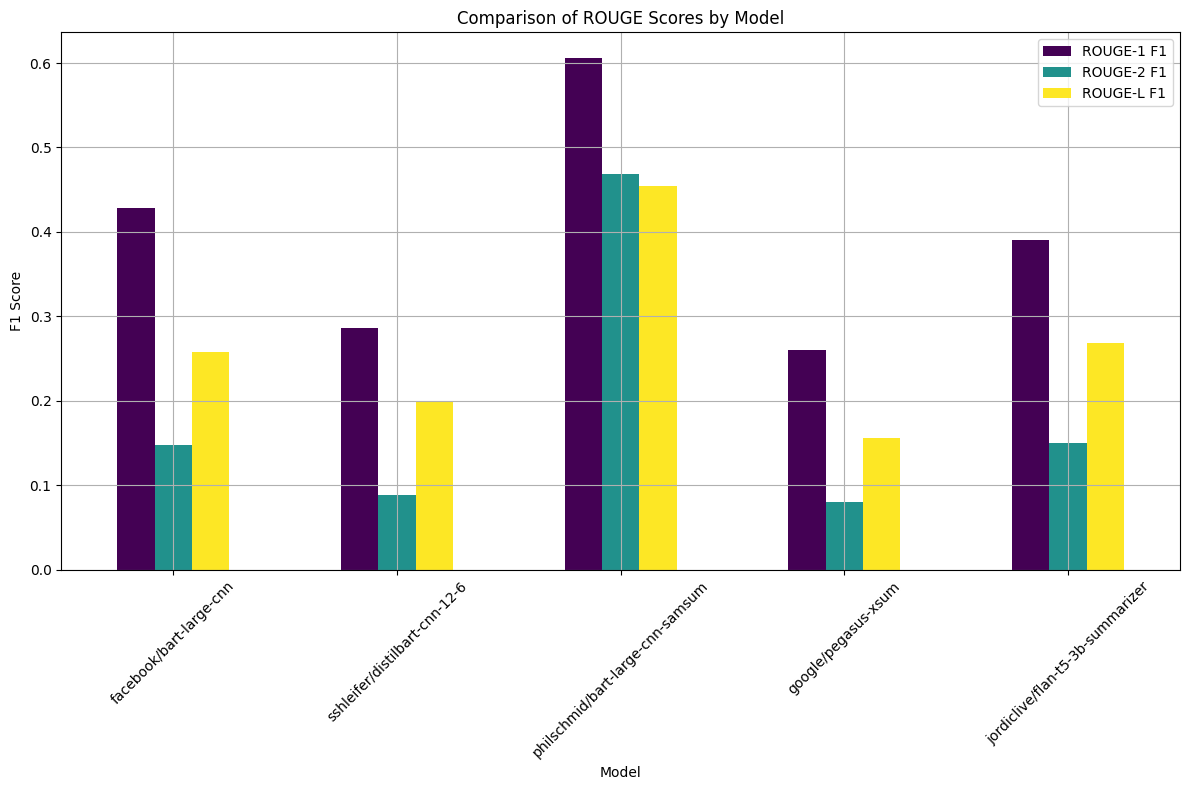

In [51]:
df_eval.plot(
    x="Model", 
    kind="bar", 
    figsize=(12, 8), 
    title="Comparison of ROUGE Scores by Model", 
    grid=True,
    colormap="viridis"
)
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print("ROUGE Scores by Model:")
display(df_eval)



ROUGE Scores by Model:


,Model,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1
0,facebook/bart-large-cnn,0.429,0.147,0.257
1,sshleifer/distilbart-cnn-12-6,0.286,0.088,0.200
2,philschmid/bart-large-cnn-samsum,0.606,0.469,0.455
3,google/pegasus-xsum,0.260,0.080,0.156
4,jordiclive/flan-t5-3b-summarizer,0.390,0.150,0.268


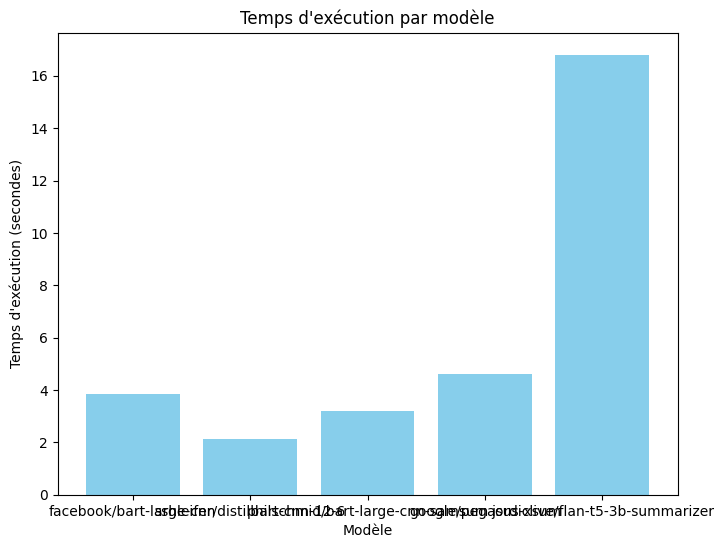

In [47]:
import matplotlib.pyplot as plt

# Créer le graphique des temps d'exécution
plt.figure(figsize=(8, 6))
plt.bar(df_results['Modèle'], df_results["Temps d'exécution (s)"], color='skyblue')
plt.xlabel('Modèle')
plt.ylabel('Temps d\'exécution (secondes)')
plt.title('Temps d\'exécution par modèle')
plt.show()

BLEU (Bilingual Evaluation Understudy)
- Évalue la similarité entre les textes générés et les références humaines.
- Appropriée pour des résumés ou traductions.

In [83]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu_score(reference, candidate):
    return sentence_bleu([reference.split()], candidate.split())

df_results['BLEU'] = df_results.apply(
    lambda row: compute_bleu_score("texte de référence", row['Résumé']),
    axis=1
)

METEOR (Metric for Evaluation of Translation with Explicit ORdering)
- Considère la synonymie et la réorganisation grammaticale.
- Plus robuste que BLEU pour des variations lexicales.

In [85]:
from nltk.translate.meteor_score import meteor_score
import nltk

# Assurez-vous d'avoir téléchargé les ressources nécessaires pour NLTK
nltk.download('punkt')

# Texte de référence tokenisé
reference_text = "The Chrysler Building, a famous art deco skyscraper in New York, will be sold for $150 million, far less than its 2008 price of $800 million."
reference_tokens = nltk.word_tokenize(reference_text)

# Calculer le score METEOR pour chaque résumé
df_results['METEOR'] = df_results.apply(
    lambda row: meteor_score([reference_tokens], nltk.word_tokenize(row['Résumé'])),
    axis=1
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\calar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install bert_score

- Utilise des embeddings BERT pour évaluer la similarité sémantique.
Pas mal pour des tâches où la compréhension est plus importante que la correspondance lexicale

In [88]:
from bert_score import score

references = ["texte de référence"] * len(df_results)
candidates = df_results['Résumé'].tolist()

P, R, F1 = score(candidates, references, lang="en", verbose=True)
df_results['BERTScore'] = F1.numpy()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.63 seconds, 7.98 sentences/sec


In [89]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# Calcul des embeddings
references_embeddings = model.encode(["texte de référence"] * len(df_results))
generated_embeddings = model.encode(df_results['Résumé'].tolist())

# Similarité cosinus
df_results['Cosine Similarity'] = [
    cosine_similarity([ref], [gen])[0][0]
    for ref, gen in zip(references_embeddings, generated_embeddings)
]

In [ ]:
# Pondération des métriques pour une note finale
df_results['Overall Score'] = (
    0.3 * df_results['ROUGE-1 F1'] +
    0.3 * df_results['BERTScore'] +
    0.2 * df_results['Cosine Similarity'] +
    0.2 * (1 / df_results['Temps d\'exécution (s)']) 
)

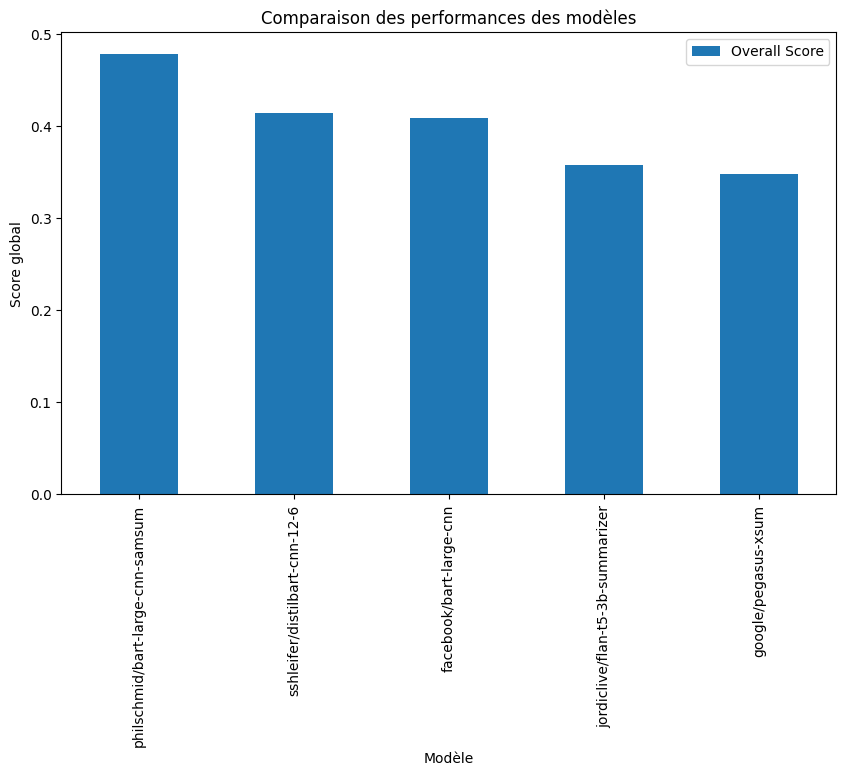

✨ Il semblerait que le modèle qui correspondrait le mieux à nos besoins soit 'philschmid/bart-large-cnn-samsum' avec un score global de 0.48. ✨


In [ ]:
import matplotlib.pyplot as plt

# Trier par score global
best_model = df_results.sort_values('Overall Score', ascending=False).iloc[0]  # Le meilleur modèle

# Graphique
df_results.sort_values('Overall Score', ascending=False).plot(
    x='Modèle', y='Overall Score', kind='bar', figsize=(10, 6),
    title='Comparaison des performances des modèles'
)
plt.ylabel('Score global')
plt.show()

from termcolor import colored

print(colored(f"✨ Il semblerait que le modèle qui correspondrait le mieux à nos besoins soit '{best_model['Modèle']}' "
              f"avec un score global de {best_model['Overall Score']:.2f}. ✨", 'green'))


In [92]:
print(df_results[['Modèle', 'ROUGE-1 F1', 'BERTScore', 'Cosine Similarity', 'Temps d\'exécution (s)', 'Overall Score']])


                             Modèle  ROUGE-1 F1  BERTScore  Cosine Similarity  \
0           facebook/bart-large-cnn       0.429      0.771             -0.015   
1     sshleifer/distilbart-cnn-12-6       0.286      0.771              0.018   
2  philschmid/bart-large-cnn-samsum       0.606      0.767              0.018   
3               google/pegasus-xsum       0.260      0.772             -0.023   
4  jordiclive/flan-t5-3b-summarizer       0.390      0.758              0.009   

   Temps d'exécution (s)  Overall Score  
0                  3.861          0.409  
1                  2.134          0.414  
2                  3.201          0.478  
3                  4.622          0.348  
4                 16.805          0.358  


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

model_name = "philschmid/bart-large-cnn-samsum"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def generate_summary_with_timing(model, tokenizer, text, min_length=50, max_length=150):
    """
    Generate summary and record the time taken.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="longest")
    start_time = time.time()
    summary_ids = model.generate(
        inputs["input_ids"],
        min_length=min_length,
        max_length=max_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    end_time = time.time()
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generation_time = end_time - start_time
    return summary, generation_time

In [104]:
# Liste des affirmations philosophiques
affirmations = [
    "Alan Turing famously laid the foundations of artificial intelligence. Today, AI can replicate human behaviors, but it lacks the capacity to suffer, to hope, or to dream. Can we truly call it intelligent if it misses the essence of human experience?",
    "Artificial intelligence has achieved the unimaginable: creating art, music, and even poetry. But every AI masterpiece is a mosaic of human ideas, values, and instructions. The machine creates, but the spark of inspiration remains deeply human.",
    "Philosophers like Nietzsche proclaimed the death of God, ushering in an era of human autonomy. Yet, with the rise of AI, humanity seems eager to hand over decision-making to algorithms. Have we found a new 'God' in artificial intelligence?",
    "Descartes’ declaration 'I think, therefore I am' defined existence by thought. But AI, despite its ability to process vast amounts of information, does not 'exist' in the Cartesian sense. It thinks, but does not feel. It acts, but does not desire.",
    "AI is not just a tool; it is a mirror. Its biases, its decisions, its outcomes reflect the imperfections of its creators. As we teach machines, we must ask ourselves: are we imparting wisdom, or are we amplifying our own flaws?"
]

In [ ]:
from IPython.core.display import display, HTML

def calculate_compression(original_text, summary_text):
    original_length = len(original_text.split())
    summary_length = len(summary_text.split())
    compression = (original_length - summary_length) / original_length * 100
    return original_length, summary_length, compression

html_output = """
<style>
    .result { 
        font-family: Arial, sans-serif; 
        border: 1px solid #ccc; 
        padding: 10px; 
        margin-bottom: 15px; 
        border-radius: 5px;
        background-color: #f9f9f9;
    }
    .header { 
        font-weight: bold; 
        color: #333; 
        margin-bottom: 10px; 
    }
    .compression {
        font-style: italic;
        color: #555;
    }
</style>
"""

for i, affirmation in enumerate(affirmations, 1):
    summary, generation_time = generate_summary_with_timing(model, tokenizer, affirmation, min_length=50, max_length=150)
    original_length, summary_length, compression = calculate_compression(affirmation, summary)
    
    html_output += f"""
    <div class='result'>
        <div class='header'>Affirmation {i} :</div>
        <p>{affirmation}</p>
        <div class='header'>Résumé généré :</div>
        <p>{summary}</p>
        <div class='compression'>
            Longueur originale : {original_length} mots | Résumé : {summary_length} mots | Compression : {compression:.2f}%
        </div>
        <div class='compression'>Temps de génération : {generation_time:.2f} secondes</div>
    </div>
    """

display(HTML(html_output))

C:\Users\calar\AppData\Local\Temp\ipykernel_16180\3799822646.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [105]:
def generate_summary_with_compression(model, tokenizer, text, target_compression=50, max_retries=5):
    """
    Generate a summary with a target compression rate using philschmid/bart-large-cnn-samsum.
    
    Parameters:
    - model: Le modèle de génération (Bart spécifique).
    - tokenizer: Le tokenizer correspondant.
    - text: Texte original à résumer.
    - target_compression: Taux de compression cible (%).
    - max_retries: Nombre maximum de tentatives pour ajuster la longueur.

    Returns:
    - summary: Résumé généré.
    - compression: Taux de compression obtenu.
    - generation_time: Temps de génération.
    """
    original_length = len(text.split())
    min_length = int(original_length * (1 - target_compression / 100))
    max_length = original_length  # Éviter que le résumé dépasse la longueur originale
    
    retries = 0
    while retries < max_retries:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="longest")
        start_time = time.time()
        
        summary_ids = model.generate(
            inputs["input_ids"],
            min_length=min_length,
            max_length=max_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )
        end_time = time.time()
        
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary_length = len(summary.split())
        compression = (original_length - summary_length) / original_length * 100
        
        # Vérifier si le taux cible est atteint
        if abs(compression - target_compression) <= 5:
            return summary, compression, end_time - start_time
        
        # Ajuster les paramètres pour se rapprocher du taux cible
        if compression < target_compression:  # Résumé trop long
            min_length -= 1
        else:  # Résumé trop court
            max_length -= 1
        
        retries += 1
    
    # Retourner le meilleur résultat après les tentatives
    return summary, compression, end_time - start_time


In [107]:

target_compression = 50  # Compression cible en %
html_output = """
<style>
    .result { 
        font-family: Arial, sans-serif; 
        border: 1px solid #ccc; 
        padding: 10px; 
        margin-bottom: 15px; 
        border-radius: 5px;
        background-color: #f9f9f9;
    }
    .header { 
        font-weight: bold; 
        color: #333; 
        margin-bottom: 10px; 
    }
    .compression {
        font-style: italic;
        color: #555;
    }
</style>
"""

for i, affirmation in enumerate(affirmations, 1):
    summary, compression, generation_time = generate_summary_with_compression(
        model, tokenizer, affirmation, target_compression=target_compression
    )
    original_length = len(affirmation.split())
    summary_length = len(summary.split())
    
    # Ajouter chaque résultat dans un format HTML
    html_output += f"""
    <div class='result'>
        <div class='header'>Affirmation {i} :</div>
        <p>{affirmation}</p>
        <div class='header'>Résumé généré :</div>
        <p>{summary}</p>
        <div class='compression'>
            Longueur originale : {original_length} mots | Résumé : {summary_length} mots | Compression : {compression:.2f}%
        </div>
        <div class='compression'>Temps de génération : {generation_time:.2f} secondes</div>
    </div>
    """

# Afficher le résultat en HTML
display(HTML(html_output))


In [109]:
def post_process_summary(summary, original_text):
    """
    Post-process the summary to retain important elements like questions or conclusions.
    """
    # Ajouter des phrases finales du texte original si elles contiennent une question ou une conclusion
    if "?" in original_text and "?" not in summary:
        summary += " " + extract_question(original_text)

    return summary

def extract_question(text):
    """
    Extract the last question from the text, if any.
    """
    sentences = text.split(".")
    questions = [s.strip() + "?" for s in sentences if "?" in s]
    return questions[-1] if questions else ""

In [112]:
def generate_summary_with_enhancements(model, tokenizer, text, target_compression=None, min_length=50, max_length=150, max_retries=5):
    """
    Generate a summary with enhancements: compression flexibility and post-processing.
    
    Parameters:
    - model: Modèle de génération.
    - tokenizer: Tokenizer correspondant au modèle.
    - text: Texte original à résumer.
    - target_compression: Taux de compression cible (%). Si None, min_length est utilisé directement.
    - min_length: Longueur minimale du résumé.
    - max_length: Longueur maximale du résumé.
    - max_retries: Nombre maximum de tentatives pour ajuster la longueur.
    
    Returns:
    - summary: Résumé généré.
    - compression: Taux de compression obtenu.
    - generation_time: Temps de génération.
    """
    original_length = len(text.split())
    
    # Ajuster min_length et max_length en fonction du taux de compression cible
    if target_compression is not None:
        min_length = int(original_length * (1 - target_compression / 100))
        max_length = original_length

    retries = 0
    while retries < max_retries:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="longest")
        start_time = time.time()
        
        summary_ids = model.generate(
            inputs["input_ids"],
            min_length=min_length,
            max_length=max_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )
        end_time = time.time()
        
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary_length = len(summary.split())
        compression = (original_length - summary_length) / original_length * 100

        
        # Vérifier si le taux cible est atteint (si défini)
        if target_compression is None or abs(compression - target_compression) <= 5:
            return post_process_summary(summary, text), compression, end_time - start_time

        # Ajuster les longueurs pour se rapprocher du taux cible
        if compression < target_compression:  # Résumé trop long
            min_length -= 1
        else:  # Résumé trop court
            max_length -= 1

        retries += 1

    # Retourner le meilleur résultat après les tentatives
    return post_process_summary(summary, text), compression, end_time - start_time

In [114]:
def calculate_compression(original_length, summary_length):
    """
    Calculer le pourcentage de compression correctement.
    """
    return (original_length - summary_length) / original_length * 100

for i, affirmation in enumerate(affirmations, 1):
    summary, compression, generation_time = generate_summary_with_enhancements(
        model, tokenizer, affirmation, target_compression=50, min_length=50, max_length=150
    )
    original_length = len(affirmation.split())
    summary_length = len(summary.split())
    compression = calculate_compression(original_length, summary_length)  # Correction ici
    
    print(f"\nAffirmation {i} : {affirmation}\n")
    print(f"Résumé généré : {summary}")
    print(f"Longueur originale : {original_length} mots | Résumé : {summary_length} mots | Compression : {compression:.2f}%")
    print(f"Temps de génération : {generation_time:.2f} secondes")
    print("=" * 80)



Affirmation 1 : Alan Turing famously laid the foundations of artificial intelligence. Today, AI can replicate human behaviors, but it lacks the capacity to suffer, to hope, or to dream. Can we truly call it intelligent if it misses the essence of human experience?

Résumé généré : Alan Turing laid the foundations of artificial intelligence. Today, AI can replicate human behaviors, but it lacks the capacity to suffer, to hope, or to dream. Can we truly call it intelligent if it misses the essence of human experience??
Longueur originale : 41 mots | Résumé : 40 mots | Compression : 2.44%
Temps de génération : 2.28 secondes

Affirmation 2 : Artificial intelligence has achieved the unimaginable: creating art, music, and even poetry. But every AI masterpiece is a mosaic of human ideas, values, and instructions. The machine creates, but the spark of inspiration remains deeply human.

Résumé généré : Artificial intelligence has achieved the unimaginable, creating art, music, and even poetry.

In [ ]:
import os

# Fonction pour lire un fichier texte
def read_text_file(file_path):
    """
    Lire le contenu d'un fichier texte.
    """
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
        return content
    else:
        raise FileNotFoundError(f"Le fichier {file_path} est introuvable.")

# Fonction pour calculer la compression
def calculate_compression(original_length, summary_length):
    """
    Calculer le pourcentage de compression.
    """
    return (original_length - summary_length) / original_length * 100

# Résumer un fichier texte avec affichage détaillé
def summarize_text_file_with_display(file_path, model, tokenizer, target_compression=50, min_length=50, max_length=150):
    """
    Lire et résumer un fichier texte, puis afficher les résultats.
    """
    try:
        # Lire le texte original
        original_text = read_text_file(file_path)
        original_length = len(original_text.split())
        
        # Générer le résumé
        summary, compression, generation_time = generate_summary_with_enhancements(
            model, tokenizer, original_text, target_compression=target_compression, min_length=min_length, max_length=max_length
        )
        summary_length = len(summary.split())
        compression = calculate_compression(original_length, summary_length)
        
        # Affichage des résultats
        print("\n--- Contenu original ---\n")
        print(original_text[:500] + "...")  # Afficher seulement les 500 premiers caractères
        print("\n--- Résumé généré ---\n")
        print(summary)
        print(f"\nLongueur originale : {original_length} mots | Longueur du résumé : {summary_length} mots")
        print(f"Compression : {compression:.2f}%")
        print(f"Temps de génération : {generation_time:.2f} secondes")
        print("=" * 80)
    except FileNotFoundError as e:
        print(str(e))

file_path = r"C:\Users\calar\OneDrive\Bureau\Mapture\backend\notebooks\comm_lesson1.txt"

summarize_text_file_with_display(
    file_path, model, tokenizer, target_compression=50, min_length=50, max_length=150
)



--- Contenu original ---

Critique of Technology (Industry)
The critique of technology, particularly in the industrial age, spans across ideological divides. On the left, thinkers like Saint-Simon, Fourier, Godin, and Karl Marx emphasized the concept of proletariat, focusing on labor and industrial consequences. On the right, figures like Martin Heidegger (1889–1976) approached it from environmental perspectives, exploring the intersection of technology and nature.

Ontology in this context is described as the "science o...

--- Résumé généré ---

The critique of technology spans across ideological divides. Martin Heidegger's Being and Time (Sein und Zeit) is a seminal work on technology and intelligence. The term "Artificial Intelligence" (AI) invites multiple layers of reflection. The word "intelligence" has a rich history of meaning tied to understanding and action. In English, the term evolved to represent the flow and communication of information, as well as specific uses in espi

In [ ]:
from flask import Flask, request, jsonify
from werkzeug.utils import secure_filename
import os
import docx  # Pour les fichiers .docx
import time  # Pour mesurer le temps de génération
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from flask_cors import CORS


app = Flask(__name__)
CORS(app, resources={r"/*": {"origins": ["http://localhost:3000", "http://192.168.x.x"]}})


UPLOAD_FOLDER = './uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Charger le modèle et le tokenizer
model_name = "philschmid/bart-large-cnn-samsum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Fonction pour vérifier les extensions autorisées
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in {'txt', 'docx'}

# Fonction pour traiter les fichiers .txt
def process_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Fonction pour traiter les fichiers .docx
def process_docx_file(file_path):
    doc = docx.Document(file_path)
    return '\n'.join([p.text for p in doc.paragraphs])

# Fonction pour calculer la compression
def calculate_compression(original_length, summary_length):
    return (original_length - summary_length) / original_length * 100

# Fonction pour générer un résumé
def generate_summary_with_enhancements(model, tokenizer, text, target_compression=None, min_length=50, max_length=150, max_retries=5):
    original_length = len(text.split())
    
    if target_compression is not None:
        min_length = int(original_length * (1 - target_compression / 100))
        max_length = original_length

    retries = 0
    while retries < max_retries:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="longest")
        start_time = time.time()
        
        summary_ids = model.generate(
            inputs["input_ids"],
            min_length=min_length,
            max_length=max_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )
        end_time = time.time()
        
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary_length = len(summary.split())
        compression = calculate_compression(original_length, summary_length)

        if target_compression is None or abs(compression - target_compression) <= 5:
            return summary, compression, end_time - start_time

        if compression < target_compression:
            min_length -= 1
        else:
            max_length -= 1

        retries += 1

    return summary, compression, end_time - start_time

# Route pour uploader un fichier et générer un résumé
@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({"error": "No file part in the request"}), 400

    file = request.files['file']

    if file.filename == '':
        return jsonify({"error": "No file selected"}), 400

    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)

        # Traiter le contenu du fichier
        if file.filename.endswith('.txt'):
            content = process_txt_file(file_path)
        elif file.filename.endswith('.docx'):
            content = process_docx_file(file_path)
        else:
            return jsonify({"error": "Unsupported file format"}), 400

        # Générer le résumé
        summary, compression, generation_time = generate_summary_with_enhancements(
            model, tokenizer, content, target_compression=50, min_length=50, max_length=150
        )
        
        # Retourner le résumé et les statistiques
        return jsonify({
            "original_text": content[:500] + "...",  # Limiter à 500 caractères pour l'aperçu
            "summary": summary,
            "original_length": len(content.split()),
            "summary_length": len(summary.split()),
            "compression": f"{compression:.2f}%",
            "generation_time": f"{generation_time:.2f} seconds"
        }), 200
    else:
        return jsonify({"error": "Invalid file type"}), 400

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)



 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.87:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1